In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output
import time

df = pd.read_csv("data/two_10000_no_noise.csv")  #csv file from generate_two.py
encoder = OneHotEncoder(sparse_output=False)
device_type_encoded = encoder.fit_transform(df[['device_type']])
features = [
    'rssi_sdr_1', 'rssi_sdr_2', 'rssi_sdr_3',
    'arrival_time_sdr_1', 'arrival_time_sdr_2', 'arrival_time_sdr_3',
    'center_freq_hz', 'packet_length_bytes'
]

In [179]:
X = np.hstack([df[features].values, device_type_encoded])
Y = df[['device_x', 'device_y', 'device_z']].values

device_ids = df['device_id'].values

In [180]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test, device_ids_train,device_ids_test = train_test_split(X_scaled, Y, device_ids, test_size=0.2, random_state=42)

In [181]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
Y_test_t = torch.tensor(Y_test, dtype=torch.float32)
# device_train_t = torch.tensor(device_ids_train, dtype = torch.float32)
# device_test_t = torch.tensor(device_ids_test, dtype=torch.float32)

In [ ]:
class RFLocalizer(nn.Module):
    def __init__(self, input_dim):
        super(RFLocalizer, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )
    def forward(self, x):
        return self.net(x)

In [183]:
import matplotlib.gridspec as gridspec

In [184]:
tv_corners = [
    (1.0, 5.0, 1.0),    # bottom-left
    (2.55, 5.0, 1.0),   # bottom-right
    (2.55, 5.0, 1.87),  # top-right
    (1.0, 5.0, 1.87),   # top-left
    (1.0, 5.0, 1.0)     # close the loop
]

In [185]:
model = RFLocalizer(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 300
batch = 10
losses = []

In [ ]:
mse_list_0, mae_list_0, rmse_list_0, acc_list_0 = [], [], [], []
loss_list, mse_list_1, mae_list_1, rmse_list_1, acc_list_1 = [], [], [], [], []
threshold = 0.5

for epoch in range(0, epochs, batch):
    for _ in range(batch):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_t)
        loss = criterion(outputs, Y_train_t)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
   
    model.eval()
    with torch.no_grad():
        preds = model(X_test_t).numpy()

    preds_0 = preds[device_ids_test == 0]
    preds_1 = preds[device_ids_test == 1]
    truth_0 = Y_test[device_ids_test == 0]
    truth_1 = Y_test[device_ids_test == 1]

    pred_mean_0 = preds_0.mean(axis=0)
    pred_mean_1 = preds_1.mean(axis=0)
    true_mean_0 = truth_0.mean(axis=0)
    true_mean_1 = truth_1.mean(axis=0)
    # Metrics
    mse_0 = mean_squared_error(truth_0, preds_0)
    mse_1 = mean_squared_error(truth_1, preds_1)

    mae_0 = mean_absolute_error(truth_0, preds_0)
    mae_1 = mean_absolute_error(truth_1, preds_1)

    rmse_0 = mse_0 ** 0.5
    rmse_1 = mse_1 ** 0.5
    acc_0 = np.mean(np.linalg.norm(truth_0 - preds_0, axis=1) < threshold)
    dist_0 = np.linalg.norm(pred_mean_0 - true_mean_0)
    acc_1 = np.mean(np.linalg.norm(truth_1 - preds_1, axis=1) < threshold)
    dist_1 = np.linalg.norm(pred_mean_1 - true_mean_1)

    loss_list.append(loss.item())
    mse_list_0.append(mse_0)
    mae_list_0.append(mae_0)
    rmse_list_0.append(rmse_0)
    acc_list_0.append(acc_0)

    mse_list_1.append(mse_1)
    mae_list_1.append(mae_1)
    rmse_list_1.append(rmse_1)
    acc_list_1.append(acc_1)

    clear_output(wait=True)
    fig = plt.figure(figsize=(18, 16))
    gs = gridspec.GridSpec(3, 4, figure=fig, height_ratios=[2.2, 1.0, 1.0])
    alphas= 0.1

    # Row 1 — 3D Views
    ax_3d_all = fig.add_subplot(gs[0, :2], projection='3d')
    ax_3d_mean = fig.add_subplot(gs[0, 2:], projection='3d')
    fig.add_subplot(gs[0, 2]).axis('off')  # leave 3rd col empty    

    #All sample 3D
    for i in range(len(tv_corners)-1):
        x, y, z = zip(tv_corners[i], tv_corners[i+1])
        ax_3d_all.plot(x, y, z, color='gray')
 
    for x, y, z in [(1.0, 5.0, 1.0), (2.45, 5.0, 1.0), (2.45, 5.0, 1.85)]:
        ax_3d_all.scatter(x, y, z, color='blue', s=100, marker='^')

    #Plot ground truth
    ax_3d_all.scatter(*true_mean_0, color='green', s=120, label='groufn Truth 0')
    ax_3d_all.scatter(*true_mean_1, color='black', s=120, label='Ground Truth 1')
    
    ax_3d_all.set_title("3D — All Predictions")
    ax_3d_all.set_xlim([0, 5]); ax_3d_all.set_ylim([0, 5]); ax_3d_all.set_zlim([0, 2.5])

    #Plot the prediction
    ax_3d_all.scatter(preds_0[:, 0], preds_0[:, 1], preds_0[:, 2], color='red', alpha=alphas, label='Device 0 Predictions')
    ax_3d_all.scatter(preds_1[:, 0], preds_1[:, 1], preds_1[:, 2], color='purple', alpha=alphas, label='Device 1 Predictions')
    ax_3d_all.set_xlabel("X"); ax_3d_all.set_ylabel("Y"); ax_3d_all.set_zlabel("Z")
    ax_3d_all.legend()


    #Mean 3D
    for i in range(len(tv_corners)-1):
        x, y, z = zip(tv_corners[i], tv_corners[i+1])
        ax_3d_mean.plot(x, y, z, color='gray')

    for x, y, z in [(1.0, 5.0, 1.0), (2.55, 5.0, 1.0), (2.55, 5.0, 1.87)]:
        ax_3d_mean.scatter(x, y, z, color='blue', s=100, marker='^')

    ax_3d_mean.set_title("3D — Mean Prediction")
    ax_3d_mean.set_xlim([0, 5]); ax_3d_mean.set_ylim([0, 5]); ax_3d_mean.set_zlim([0, 2.5])
    ax_3d_mean.scatter(*pred_mean_0, color='red', s=120, label='Pred Mean 0', alpha = 0.8)
    ax_3d_mean.scatter(*pred_mean_1, color='purple', s=120, label='Pred Mean 1', alpha = 0.8)

    ax_3d_mean.scatter(*true_mean_0, color='green', s=120, label='Ground Truth 0', alpha = 0.8)
    ax_3d_mean.scatter(*true_mean_1, color='black', s=120, label='Ground Truth 1', alpha = 0.8)

    ax_3d_mean.set_title("3D — Mean Predictions (Both Devices)")
    ax_3d_mean.set_xlim([0, 5]); ax_3d_mean.set_ylim([0, 5]); ax_3d_mean.set_zlim([0, 2.5])
    ax_3d_mean.set_xlabel("X"); ax_3d_mean.set_ylabel("Y"); ax_3d_mean.set_zlabel("Z")
    ax_3d_mean.legend()


    # Row 2 — Plane Projections (All samples)
    ax_xy_all = fig.add_subplot(gs[1, 0])
    ax_xz_all = fig.add_subplot(gs[1, 1])
    ax_yz_all = fig.add_subplot(gs[1, 2])
    # XY plane
    ax_xy_all.set_xlim([0, 5])
    ax_xy_all.set_ylim([0, 5])
    ax_xy_all.set_title("XY Plane — All Predictions")
    ax_xy_all.grid(True)
    # XZ plane
    ax_xz_all.set_xlim([0, 5])
    ax_xz_all.set_ylim([0, 2.5])
    ax_xz_all.set_title("XZ Plane — All Predictions")
    ax_xz_all.grid(True)
    # YZ plane
    ax_yz_all.set_xlim([0, 5])
    ax_yz_all.set_ylim([0, 2.5])
    ax_yz_all.set_title("YZ Plane — All Predictions")
    ax_yz_all.grid(True)


    # Row 3 — Plane Projections (Mean)
    ax_xy_mean = fig.add_subplot(gs[2, 0])
    ax_xz_mean = fig.add_subplot(gs[2, 1])
    ax_yz_mean = fig.add_subplot(gs[2, 2])
    #XY Plane
    ax_xy_mean.set_xlim([0, 5])
    ax_xy_mean.set_ylim([0, 5])
    ax_xy_mean.set_title("XY Plane — Mean Predictions")
    ax_xy_mean.grid(True)
    #XZ Plane
    ax_xz_mean.set_xlim([0, 5])
    ax_xz_mean.set_ylim([0, 2.5])
    ax_xz_all.set_title("XZ Plane — Mean Predictions")
    ax_xz_mean.grid(True)
    #YZ Plane
    ax_yz_mean.set_xlim([0, 5])
    ax_yz_mean.set_ylim([0, 2.5])
    ax_yz_all.set_title("YZ Plane — Mean Predictions")
    ax_yz_mean.grid(True)


    # All samples
    ax_xy_all.scatter(preds_0[:, 0], preds_0[:, 1], color='red', alpha=alphas)
    ax_xz_all.scatter(preds_0[:, 0], preds_0[:, 2], color='red', alpha=alphas)
    ax_yz_all.scatter(preds_0[:, 1], preds_0[:, 2], color='red', alpha=alphas)

    ax_xy_all.scatter(preds_1[:, 0], preds_1[:, 1], color='purple', alpha=alphas)
    ax_xz_all.scatter(preds_1[:, 0], preds_1[:, 2], color='purple', alpha=alphas)
    ax_yz_all.scatter(preds_1[:, 1], preds_1[:, 2], color='purple', alpha=alphas)

    # Ground truth for all samples
    ax_xy_all.scatter(true_mean_0[0], true_mean_0[1], color='green')
    ax_xz_all.scatter(true_mean_0[0], true_mean_0[2], color='green')
    ax_yz_all.scatter(true_mean_0[1], true_mean_0[2], color='green')

    ax_xy_all.scatter(true_mean_1[0], true_mean_1[1], color='black')
    ax_xz_all.scatter(true_mean_1[0], true_mean_1[2], color='black')
    ax_yz_all.scatter(true_mean_1[1], true_mean_1[2], color='black')

    # Mean
    ax_xy_mean.scatter(pred_mean_0[0], pred_mean_0[1], color='red', alpha=0.7)
    ax_xz_mean.scatter(pred_mean_0[0], pred_mean_0[2], color='red', alpha=0.7)
    ax_yz_mean.scatter(pred_mean_0[1], pred_mean_0[2], color='red', alpha=0.7)

    ax_xy_mean.scatter(pred_mean_1[0], pred_mean_1[1], color='purple', alpha=0.7)
    ax_xz_mean.scatter(pred_mean_1[0], pred_mean_1[2], color='purple', alpha=0.7)
    ax_yz_mean.scatter(pred_mean_1[1], pred_mean_1[2], color='purple', alpha=0.7)

    # Ground truth for mean values
    ax_xy_mean.scatter(true_mean_0[0], true_mean_0[1], color='green', alpha=0.7)
    ax_xz_mean.scatter(true_mean_0[0], true_mean_0[2], color='green', alpha=0.7)
    ax_yz_mean.scatter(true_mean_0[1], true_mean_0[2], color='green', alpha=0.7)

    ax_xy_mean.scatter(true_mean_1[0], true_mean_1[1], color='black', alpha=0.7)
    ax_xz_mean.scatter(true_mean_1[0], true_mean_1[2], color='black', alpha=0.7)
    ax_yz_mean.scatter(true_mean_1[1], true_mean_1[2], color='black', alpha=0.7)

    # Print the metrics
    plt.suptitle(f"Device 0: Epoch {epoch+batch} | MAE: {mae_0:.4f} | RMSE: {rmse_0:.4f} | Accuracy: {acc_0:.4f}\n"
                f"Ground Truth:{true_mean_0.round(4)} | Prediction: {pred_mean_0.round(4)} | Distance Error: {dist_0:.4f}\n"
                f"Device 1: Epoch {epoch+batch} | MAE: {mae_1:.4f} | RMSE: {rmse_1:.4f} | Accuracy: {acc_1:.4f}\n"
                f"Ground Truth:{true_mean_1.round(4)} | Prediction: {pred_mean_1.round(4)} | Distance Error: {dist_1:.4f} m",
                fontsize=20)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"frames/frame_{epoch+batch:04d}.png") #save the frames
    plt.close()

#### Run 
ffmpeg -framerate 5 -pattern_type glob -i 'frames/frame_*.png' -c:v libx264 -pix_fmt yuv420p frame.mp4

In [ ]:
epoch_steps = list(range(batch, epochs + 1, batch))
metrics_df = pd.DataFrame({
    "Epoch": epoch_steps,
    "Loss": loss_list,
    "MSE for 0": mse_list_0,
    "MAE for 0": mae_list_0,
    "RMSE for 0": rmse_list_0,
    "Accuracy for 0": acc_list_0,
    "MSE for 1": mse_list_1,
    "MAE for 1": mae_list_1,
    "RMSE for 1": rmse_list_1,
    "Accuracy for 1": acc_list_1
})

print(metrics_df.round(4).to_string(index=False)) 
metrics_df.to_csv("metrics.csv", index=False) ## save the metrics as csv

 Epoch   Loss  MSE for 0  MAE for 0  RMSE for 0  Accuracy for 0  MSE for 1  MAE for 1  RMSE for 1  Accuracy for 1
    10 3.8312     2.2202     1.3963      1.4900          0.0000     5.2198     1.7872      2.2847          0.0000
    20 2.6957     1.2720     1.0195      1.1278          0.0000     3.8665     1.4869      1.9663          0.0000
    30 1.4759     0.4272     0.5078      0.6536          0.0000     2.2881     1.2226      1.5126          0.0000
    40 0.5956     0.1483     0.3118      0.3851          0.1590     0.9270     0.8698      0.9628          0.0000
    50 0.2277     0.1137     0.2771      0.3372          0.5523     0.2925     0.4352      0.5409          0.0000
    60 0.0732     0.0355     0.1517      0.1885          0.9594     0.0913     0.2420      0.3021          0.5785
    70 0.0184     0.0215     0.1240      0.1465          1.0000     0.0115     0.0751      0.1072          0.9919
    80 0.0121     0.0105     0.0821      0.1027          1.0000     0.0137     0.1007   

In [188]:
print(f"[Device 0] MAE: {mae_0:.4f}, RMSE: {rmse_0:.4f}")
print(f"[Device 1] MAE: {mae_1:.4f}, RMSE: {rmse_1:.4f}")

[Device 0] MAE: 0.0236, RMSE: 0.0310
[Device 1] MAE: 0.0206, RMSE: 0.0280


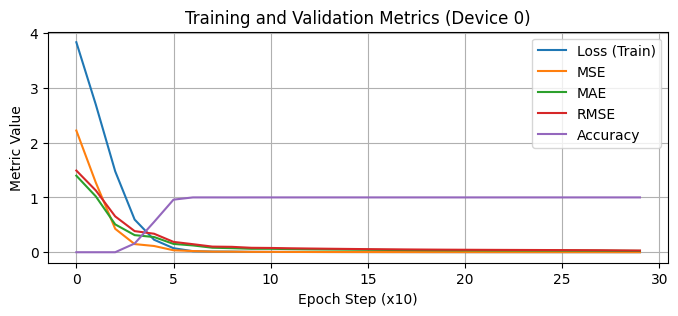

In [ ]:
# plot the metrics for Device 0
plt.figure(figsize=(8, 3))
plt.plot(loss_list, label='Loss (Train)')
plt.plot(mse_list_0, label='MSE')
plt.plot(mae_list_0, label='MAE')
plt.plot(rmse_list_0, label='RMSE')
plt.plot(acc_list_0, label='Accuracy')
plt.xlabel("Epoch Step (x10)")
plt.ylabel("Metric Value")
plt.title("Training and Validation Metrics (Device 0)")
plt.grid()
plt.legend()
plt.show()

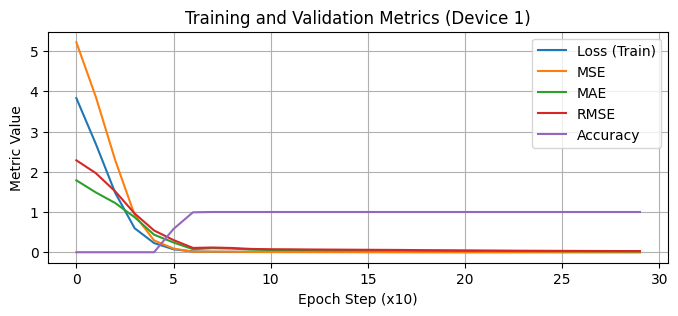

In [ ]:
# Plot the metrics for Device 1
plt.figure(figsize=(8, 3))
plt.plot(loss_list, label='Loss (Train)')
plt.plot(mse_list_1, label='MSE')
plt.plot(mae_list_1, label='MAE')
plt.plot(rmse_list_1, label='RMSE')
plt.plot(acc_list_1, label='Accuracy')
plt.xlabel("Epoch Step (x10)")
plt.ylabel("Metric Value")
plt.title("Training and Validation Metrics (Device 1)")
plt.grid()
plt.legend()
plt.show()